<a href="https://colab.research.google.com/github/armishra111/Efficient-Trading-with-Price-Impact/blob/main/Efficient_Trading_with_Price_Impact.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy.optimize import root_scalar

# Load the merged data
data = pd.read_csv('merged_data.csv')

In [4]:
#Code written in Google colab for convenience. Google colab offers gemini integration for the code. Used the gemini assist to label variables nicely.

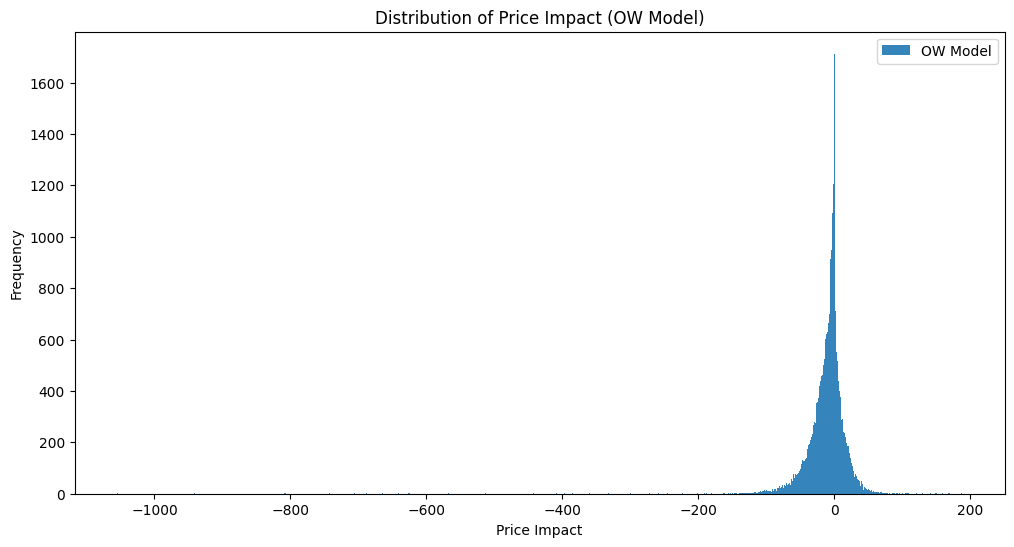

In [3]:
def ow_model(data, lambda_val, beta_val):
    """
    Calculates price impact using the Obizhaeva and Wang (OW) model.

    Args:
        data (pd.DataFrame): The merged data.
        lambda_val (float): Impact level parameter.
        beta_val (float): Impact decay parameter.

    Returns:
        pd.Series: Price impact series.
    """
    # Calculate the exponentially weighted moving average of signed volume as defined in the source paper in section 2.3 just below the definition of OW model
    data['ewma_volume'] = data['signed_volume'].ewm(alpha=1-np.exp(-beta_val), adjust=False).mean()
    # Calculate price impact
    price_impact = lambda_val * data['ewma_volume']
    return price_impact

# Set parameters for the OW model
lambda_ow = 0.01  # impact level
beta_ow = 0.1     # impact decay

# Calculate price impact using the OW model
ow_impact = ow_model(data.copy(), lambda_ow, beta_ow)

# Visualize the distribution
plt.figure(figsize=(12, 6))
plt.hist(ow_impact, bins=1000, alpha=0.9, label='OW Model')
plt.xlabel('Price Impact')
plt.ylabel('Frequency')
plt.legend()
plt.title('Distribution of Price Impact (OW Model)')
plt.show()


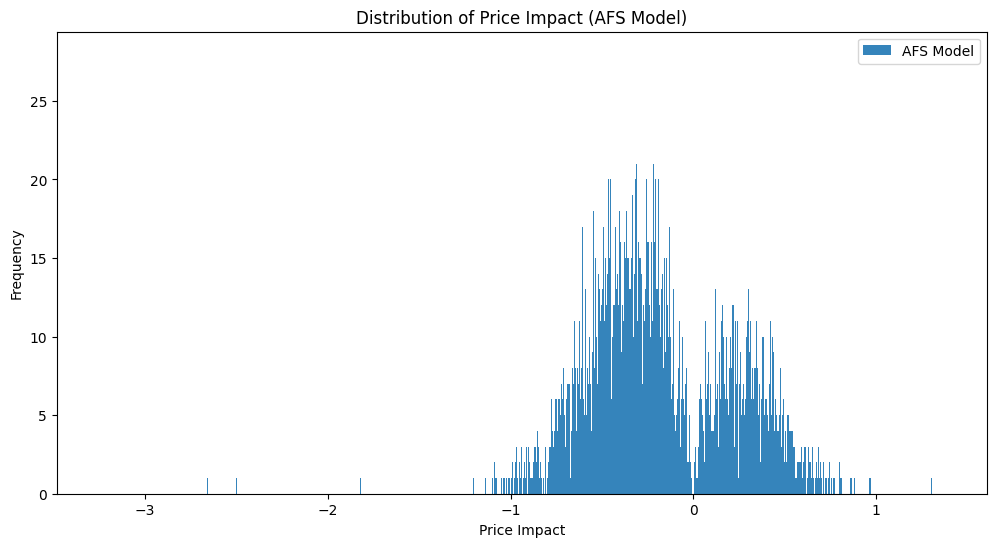

In [7]:
def afs_model(data, lambda_val, beta_val, p_val=0.5):
    """
    Calculates price impact using the Alfonsi, Fruth, and Schied (AFS) model.

    Args:
        data (pd.DataFrame): The merged data.
        lambda_val (float): Impact level parameter.
        beta_val (float): Impact decay parameter.
        p_val (float): Power law exponent (0.5 for square-root impact).

    Returns:
        pd.Series: Price impact series.
    """
    # Calculate the exponentially weighted moving average of signed volume
    data['ewma_volume'] = data['signed_volume'].ewm(alpha=1-np.exp(-beta_val), adjust=False).mean()
    # Calculate price impact with nonlinearity
    price_impact = lambda_val * np.sign(data['ewma_volume']) * np.abs(data['ewma_volume'])**p_val
    return price_impact

#Set parameters for the AFS model
lambda_afs = 0.01  # impact level
beta_afs = 0.1     # impact decay

# Calculate price impact using the AFS model
afs_impact = afs_model(data.copy(), lambda_afs, beta_afs)

# Visualize the distribution
plt.figure(figsize=(12, 6))
plt.hist(afs_impact, bins=10000, alpha=0.9, label='AFS Model')
plt.xlabel('Price Impact')
plt.ylabel('Frequency')
plt.legend()
plt.title('Distribution of Price Impact (AFS Model)')
plt.show()

In [13]:
# Mean reversion to find trading signal as seen from section 2.1

def simulate_mean_reverting_signal(data, phi_val, dt_val=1):
    """
    Simulates a mean-reverting trading signal.

    Args:
        data (pd.DataFrame): DataFrame to add the signal to.
        phi_val (float): Mean reversion parameter.
        dt_val (float): Time step (default: 1/252 for daily data).

    Returns:
        pd.DataFrame: DataFrame with the simulated signal ('ft').
    """

    data['ft'] = 0.0  # Initialize the signal column

    for i in range(1, len(data)):
        # Generate a standard normal random variable
        # dW = np.random.normal(0, np.sqrt(dt_val))
        dW = np.random.normal(0, 1) * np.sqrt(dt_val)
        # Discretize the mean-reverting SDE
        data.loc[i,'ft'] = data['ft'][i-1] - phi_val * data['ft'][i-1] * dt_val + np.sqrt(2 * phi_val) * dW #df_t = −φ*f_t*dt + \sqrt(2φ)*dW_t
    return data

# Set the mean reversion parameter (from Section 6.1 of the source)
phi = 0.139

# Simulate the signal and add it to the DataFrame
data = simulate_mean_reverting_signal(data, phi)

In [14]:
# Define the risk_squared function (from Theorem 4.2)
def risk_squared(gamma, alpha, sigma, beta, phi, lambda_val, target_risk_squared):
    """Calculates the difference between the squared risk from formula 4.4 and the target risk squared.

    Args:
        gamma: The risk aversion parameter.
        alpha: A parameter regulating the accuracy of return predictions.
        sigma: The volatility of price shocks.
        beta: The impact decay rate.
        phi: The mean reversion parameter of the trading signal.
        lambda_val: The impact level.
        target_risk_squared: The desired squared risk level.

    Returns:
        The difference between the calculated squared risk and the target risk squared.
    """
    term1 = alpha**2 * sigma**2 / (gamma * sigma**2)**2
    term2 = (beta / phi + 1)**2
    term3 = (beta / phi / np.sqrt(1 + 2 * lambda_val * beta / (gamma * sigma**2)) + 1)
    term4 = 1 / np.sqrt(1 + 2 * lambda_val * beta / (gamma * sigma**2))
    term5 = (np.sqrt(1 + 2 * lambda_val * beta / (gamma * sigma**2)) + beta / phi)**3

    calculated_risk_squared = term1 * term2 * term3 * term4 * term5
    return calculated_risk_squared - target_risk_squared


# Set model parameters
alpha = 1.67e-4
sigma = 0.02
beta = 2
phi = 0.139
lambda_val = 0.0035

# Set the target daily risk (DR)
target_daily_risk = 1.3e6

# Calculate the target squared risk
target_risk_squared = target_daily_risk**2

# Use root_scalar to find gamma
sol = root_scalar(risk_squared, args=(alpha, sigma, beta, phi, lambda_val, target_risk_squared),
                    bracket=[1e-10, 1e6], method='brentq')

# The solution object contains the value of gamma that satisfies the risk constraint
gamma = sol.root
risk_aversion = gamma  # Store the calculated risk aversion parameter
print(f"The risk aversion parameter is: {risk_aversion}")

The risk aversion parameter is: 7.185645623160557e-05


In [15]:
def optimal_linear_strategy(data, alpha_val, gamma_val, sigma_val, phi_val, lambda_val, beta_val):
    """
    Calculates the optimal trading strategy with linear impact and exponential decay.

    Args:
        data (pd.DataFrame): The merged data containing the trading signal (ft).
        alpha_val (float): Trading signal accuracy parameter.
        gamma_val (float): Risk aversion parameter.
        sigma_val (float): Volatility of the risky asset.
        phi_val (float): Mean reversion parameter of the trading signal.
        lambda_val (float): Impact level parameter.
        beta_val (float): Impact decay parameter.

    Returns:
        pd.DataFrame: DataFrame with the original data and the optimal holdings (Qt).
    """

    # Calculate the coefficients Cf and CJ
    Cf = alpha_val * (1 + beta_val / phi_val) / (gamma_val * sigma_val**2 * (np.sqrt(1 + 2 * lambda_val * beta_val / (gamma_val * sigma_val**2)) + beta_val / phi_val))
    CJ = np.sqrt(1 + 2 * lambda_val * beta_val / (gamma_val * sigma_val**2)) - 1

    # Initialize Jt (accumulated impact) to 0
    data['Jt'] = 0.0
    # Initialize Qt to 0
    data['Qt'] = 0.0

    # Calculate the optimal holdings (Qt) iteratively
    for i in range(1, len(data)):
        data.loc[i,'Jt'] = np.exp(-beta_val) * data['Jt'][i-1] + data['signed_volume'][i]  # Update Jt
        data.loc[i,'Qt'] = Cf * data['ft'][i] - CJ * data['Jt'][i]  # Calculate Qt using the coefficients

    return data


# Example: Set parameters for the optimal linear strategy
alpha = 1.67e-4  # From Section 6.1
sigma = 0.02     # From Section 6.1
phi = 0.139      # From Section 6.1
lambda_lin = 0.0035  # From Section 6.1
beta = 2         # From Section 6.1

data_with_holdings = optimal_linear_strategy(data.copy(), alpha, gamma, sigma, phi, lambda_lin, beta)

# Now the DataFrame 'data_with_holdings' contains the optimal holdings 'Qt'


In [16]:
data_with_holdings.head(20)

,ts_event,bid_fill,ask_fill,signed_volume,price,best_bid,best_ask,mid_price,ft,Jt,Qt
0,2024-10-22 08:00:00,801.0,1999.0,-1198.0,236.14,235.83,236.14,235.985,0.000000,0.000000,0.000000e+00
1,2024-10-22 08:00:01,201.0,202.0,-1.0,236.13,235.83,236.13,235.980,0.092088,-1.000000,7.084726e+02
2,2024-10-22 08:00:02,1600.0,1400.0,200.0,235.83,235.83,236.11,235.970,-0.099770,199.864665,-1.393009e+05
3,2024-10-22 08:00:03,534.0,400.0,134.0,236.10,235.96,236.10,236.030,-0.191139,161.048741,-1.122610e+05
4,2024-10-22 08:00:04,400.0,502.0,-102.0,236.11,235.96,236.11,236.035,0.601658,-80.204423,5.597106e+04
5,2024-10-22 08:00:05,464.0,869.0,-405.0,236.11,235.96,236.11,236.035,0.607397,-415.854488,2.898908e+05
6,2024-10-22 08:00:08,116.0,760.0,-644.0,236.09,235.96,236.09,236.025,0.210544,-700.279785,4.880608e+05
7,2024-10-22 08:00:09,2245.0,4211.0,-1966.0,235.83,235.81,235.83,235.820,-0.528183,-2060.772563,1.436114e+06
8,2024-10-22 08:00:12,45.0,2341.0,-2296.0,236.01,235.81,236.01,235.910,-0.832885,-2574.895239,1.794375e+06
9,2024-10-22 08:00:16,3408.0,2846.0,562.0,235.97,235.81,235.97,235.890,-0.377758,213.525824,-1.488564e+05


In [18]:
from scipy.optimize import minimize
from scipy.special import gamma

def risk_squared(risk_aversion, impact_level, impact_decay, alpha, sigma, phi):
  """
  Calculates the squared risk of the linear strategy for given parameters.

  Args:
    risk_aversion: Risk aversion parameter (gamma).
    impact_level: Impact level parameter (lambda).
    impact_decay: Impact decay parameter (beta).
    alpha: Signal strength parameter.
    sigma: Volatility of the risky asset.
    phi: Mean reversion parameter of the signal.

  Returns:
    Squared risk of the strategy.
  """
  # Calculate repeated terms
  sqrt_term = np.sqrt(1 + 2 * impact_level * impact_decay / (risk_aversion * sigma**2))
  beta_phi_ratio = impact_decay / phi

  return (alpha**2 * sigma**2 / (risk_aversion * sigma**2)**2 *
          (beta_phi_ratio + 1)**2 * (beta_phi_ratio / sqrt_term + 1) *
          sqrt_term / (sqrt_term + beta_phi_ratio)**3)

def pnl_one_timescale(impact_level, impact_decay, risk_aversion, alpha, sigma, phi, p, lambda_n, beta_n):
  """
  Calculates the expected PnL per unit time net of nonlinear impact costs
  for one decay timescale.

  Args:
    impact_level: Effective impact level (lambda).
    impact_decay: Effective impact decay (beta).
    risk_aversion: Risk aversion parameter (gamma).
    alpha: Signal strength parameter.
    sigma: Volatility of the risky asset.
    phi: Mean reversion parameter of the signal.
    p: Power law exponent for the impact function.
    lambda_n: Impact level parameter for the single timescale.
    beta_n: Impact decay parameter for the single timescale.

  Returns:
    Expected PnL per unit time net of trading costs.
  """
  # Pre-calculate repeated terms
  xi = np.sqrt(risk_aversion * sigma**2 * (risk_aversion * sigma**2 + 2 * impact_level * impact_decay))
  gamma_term = gamma(p / 2) * p / (2 * np.sqrt(np.pi))
  common_term = (2 * alpha**2 * risk_aversion**2 * sigma**4 * phi * (impact_decay + phi)**2) / (xi * (phi * xi + risk_aversion * impact_decay * sigma**2)**3)

  # PnL calculation for one timescale
  pnl_value = (alpha**2 * risk_aversion * sigma**2 * (impact_decay + phi)**2 / (impact_decay * risk_aversion * sigma**2 + xi * phi)**2 -
               gamma_term * beta_n * lambda_n *
                      common_term * (impact_decay**2 * xi + impact_decay * beta_n * xi + risk_aversion * beta_n * sigma**2 * (impact_decay + phi))**((p + 1) / 2) /
                      ((beta_n + phi) * (risk_aversion * impact_decay * sigma**2 + beta_n * xi)))

  return pnl_value


def sharpe_ratio_one_timescale(impact_level, impact_decay, target_risk_squared, alpha, sigma, phi, p, lambda_n, beta_n):
  """
  Calculates the Sharpe ratio for given impact parameters for one decay timescale.

  Args:
    impact_level: Effective impact level (lambda).
    impact_decay: Effective impact decay (beta).
    target_risk_squared: Target risk squared for the portfolio.
    alpha: Signal strength parameter.
    sigma: Volatility of the risky asset.
    phi: Mean reversion parameter of the signal.
    p: Power law exponent for the impact function.
    lambda_n: Impact level parameter for the single timescale.
    beta_n: Impact decay parameter for the single timescale.

  Returns:
    Sharpe ratio of the strategy.
  """

  # Use a more efficient optimization algorithm
  result = minimize(lambda risk_aversion: (risk_squared(risk_aversion, impact_level, impact_decay, alpha, sigma, phi) - target_risk_squared)**2,
                    x0=1.0, method='L-BFGS-B', bounds=[(1e-6, 1e6)])
  risk_aversion = result.x

  risk = np.sqrt(risk_squared(risk_aversion, impact_level, impact_decay, alpha, sigma, phi))
  pnl_value = pnl_one_timescale(impact_level, impact_decay, risk_aversion, alpha, sigma, phi, p, lambda_n, beta_n)

  return pnl_value / risk

# Example usage:
# Market parameters
alpha = 1.67e-4  # Signal strength parameter
sigma = 0.02    # Volatility of the risky asset
phi = 0.139      # Mean reversion parameter (half-life of 5 days)

# Price impact model parameters (single timescale)
p = 0.5       # Square-root impact function
lambda_n = 0.0035 # Impact level parameter
beta_n = 2       # Impact decay parameter (half-life of 1/3 day)

# Target risk for the portfolio
target_risk = 1.3e6  # Daily risk target
target_risk_squared = target_risk**2

# Bounds for impact level and impact decay
impact_level_bounds = (1e-10, 1e5)
impact_decay_bounds = (1e-10, 1e8)

# Define the objective function for optimization
def objective_function(params):
  impact_level, impact_decay = params
  return -sharpe_ratio_one_timescale(impact_level, impact_decay, target_risk_squared, alpha, sigma, phi, p, lambda_n, beta_n)

# Perform optimization
result = minimize(objective_function, x0=[5e-4, 2], method='L-BFGS-B', bounds=[impact_level_bounds, impact_decay_bounds])

# Optimal values
optimal_impact_level, optimal_impact_decay = result.x

# Convergence check parameters
tolerance = float(1e-10)  # Tolerance for convergence
max_iterations = 100  # Maximum number of iterations

# Initialize lists to store optimal parameters for each iteration
optimal_impact_levels = []
optimal_impact_decays = []

# Optimization loop with convergence check
for iteration in range(max_iterations):
  # Perform optimization (same as before)
  result = minimize(objective_function, x0=[5e-4, 2], method='L-BFGS-B',
                    bounds=[impact_level_bounds, impact_decay_bounds])

  # Optimal values for current iteration
  optimal_impact_level, optimal_impact_decay = result.x

  # Store optimal parameters
  optimal_impact_levels.append(optimal_impact_level)
  optimal_impact_decays.append(optimal_impact_decay)

  # Check for convergence
  if iteration > 0:
    impact_level_change = abs(optimal_impact_levels[-1] - optimal_impact_levels[-2])
    impact_decay_change = abs(optimal_impact_decays[-1] - optimal_impact_decays[-2])

    if impact_level_change < tolerance and impact_decay_change < tolerance:
      print(f"Convergence achieved after {iteration + 1} iterations.")
      break

  print(f"Iteration {iteration + 1}: lambda* = {optimal_impact_level}, beta* = {optimal_impact_decay}")

# Final optimal values
optimal_impact_level = optimal_impact_levels[-1]
optimal_impact_decay = optimal_impact_decays[-1]

print("\nFinal Optimal Values:")
print("Optimal impact level (lambda*):", optimal_impact_level)
print("Optimal impact decay (beta*):", optimal_impact_decay)

Iteration 1: lambda* = 0.0013647584141594673, beta* = 216784.45736059788
Convergence achieved after 2 iterations.

Final Optimal Values:
Optimal impact level (lambda*): 0.0013647584141594673
Optimal impact decay (beta*): 216784.45736059788


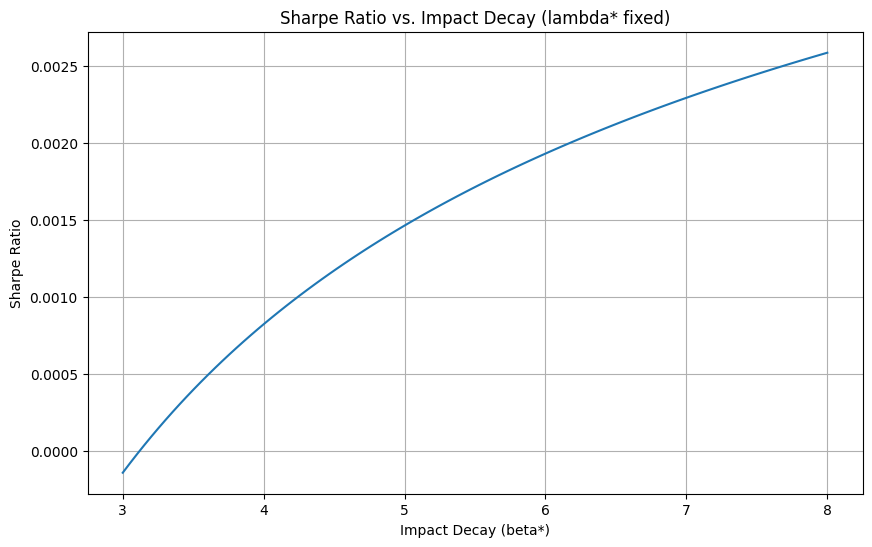

In [19]:
# Create a range of impact decay values
beta_star_range = np.linspace(3, 8, 100)

# Calculate the corresponding Sharpe ratios
sharpe_ratios = []
for beta_star in beta_star_range:
    sharpe_ratios.append(sharpe_ratio_one_timescale(optimal_impact_level, beta_star, target_risk_squared, alpha, sigma, phi, p, lambda_n, beta_n))

# Plot Sharpe ratio vs. impact decay
plt.figure(figsize=(10, 6))
plt.plot(beta_star_range, sharpe_ratios)
plt.xlabel("Impact Decay (beta*)")
plt.ylabel("Sharpe Ratio")
plt.title("Sharpe Ratio vs. Impact Decay (lambda* fixed)")
plt.grid(True)
plt.show()

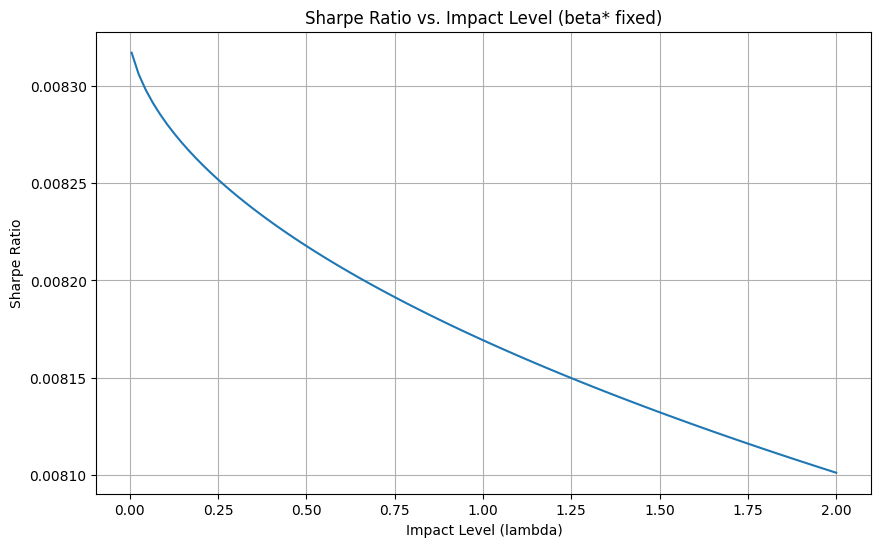

In [20]:
# Create a range of lambda values
lambda_star_range = np.linspace(0.005, 2, 100)


# Calculate the corresponding Sharpe ratios
sharpe_ratios = []
for lambda_star in lambda_star_range:
    sharpe_ratios.append(sharpe_ratio_one_timescale(lambda_star, optimal_impact_decay, target_risk_squared, alpha, sigma, phi, p, lambda_n, beta_n))

# Plot Sharpe ratio vs. lambda
plt.figure(figsize=(10, 6))
plt.plot(lambda_star_range, sharpe_ratios)
plt.xlabel("Impact Level (lambda)")
plt.ylabel("Sharpe Ratio")
plt.title("Sharpe Ratio vs. Impact Level (beta* fixed)")
plt.grid(True)
plt.show()